# Graph Cut search problem with Grover Oracle

## Introduction

The "Maximum Cut Problem" (MaxCut) [[1](#MaxCutWiki)] is an example of combinatorial optimization problem. It refers to finding a partition of a graph into two sets, such that the number of edges between the two sets is maximal.

## Mathematical formulation

Given a graph $G=(V,E)$ with $|V|=n$ nodes and $E$ edges, a cut is defined as a partition of the graph into two complementary subsets of nodes. In the MaxCut problem we are looking for a cut where the number of edges between the two subsets is maximal. We can represent a cut of the graph by a binary vector $x$ of size $n$, where we assign 0 and 1 to nodes in the first and second subsets, respectively. The number of connecting edges for a given cut is simply given by summing over $x_i (1-x_j)+x_j (1-x_i)$ for every pair of connected nodes $(i,j)$.

# Solving with the Classiq platform


### Necessary Packages

In this demo, besides the `classiq` package, we'll use the following packages:

In [1]:
%%capture
! pip install networkx
! pip install pyomo
! pip install sympy
! pip install matplotlib

In this tutorial we define a **search problem** instead: Given a graph and number of edges, check if there is a cut in the grpah that We will solve the problem using the grover algorithm.

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from sympy import simplify

### Define the cut search problem

In [3]:
def is_cross_cut_edge(x1: int, x2: int) -> int:
    return x1 * (1 - x2) + x2 * (1 - x1)


def generate_maxcut_formula(graph: nx.Graph, cut_size) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)

    model.cut_edges_constraint = pyo.Constraint(
        expr=sum(
            is_cross_cut_edge(model.x[node1], model.x[node2])
            for (node1, node2) in graph.edges
        )
        >= cut_size
    )

    expr = str(model.cut_edges_constraint.expr)
    for i in graph.nodes:
        expr = expr.replace(f"[{i}]", f"{i}")
    expr = str(simplify(expr))
    return expr

### Define a speific problem input

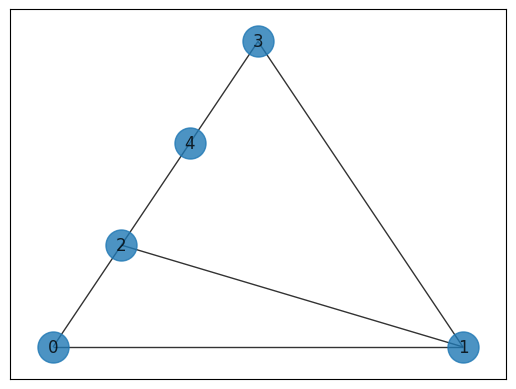

In [4]:
# Create graph
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)])
pos = nx.planar_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=True, alpha=0.8, node_size=500)

here we look for a cut of size 4 to the graph:

In [5]:
formula = generate_maxcut_formula(G, cut_size=4)
print(formula)

2*x0*x1 + 2*x0*x2 - 2*x0 + 2*x1*x2 + 2*x1*x3 - 3*x1 + 2*x2*x4 - 3*x2 + 2*x3*x4 - 2*x3 - 2*x4 <= -4


## Creating quantum circuit from the problem formulation and solving it using the Classiq platform

In [6]:
from classiq import RegisterUserInput, construct_grover_model

register_size = RegisterUserInput(size=1)

qmod = construct_grover_model(
    num_reps=3,
    expression=formula,
    definitions=[(f"x{i}", RegisterUserInput(size=1)) for i in G.nodes],
)

## Synthesizing the Circuit

We proceed by synthesizing the circuit using Classiq's synthesis engine. The synthesis should take approximately several seconds:

In [7]:
from classiq import Constraints, QuantumProgram, set_constraints, synthesize

qmod = set_constraints(qmod, Constraints(max_width=22))

In [8]:
from classiq import write_qmod

write_qmod(qmod, "grover_max_cut")

In [9]:
qprog = synthesize(qmod)

## Showing the Resulting Circuit

After Classiq's synthesis engine has finished the job, we can show the resulting circuit in the interactive GUI:

In [10]:
from classiq import show

show(qprog)

Opening: https://platform.classiq.io/circuit/4042996b-8045-4645-8707-69e6cd39b9ef?version=0.38.0.dev42%2Bfd36e2c41c


In [11]:
circuit = QuantumProgram.from_qprog(qprog)

print(circuit.transpiled_circuit.depth)

2559


### Execute the problem on a simulator and try to find a valid solution
Lastly, we can execute the resulting circuit with Classiq's execute interface, using the `execute` function.

In [12]:
from classiq import execute, set_quantum_program_execution_preferences
from classiq.execution import (
    ClassiqBackendPreferences,
    ExecutionDetails,
    ExecutionPreferences,
)

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qprog = set_quantum_program_execution_preferences(qprog, backend_preferences)
optimization_result = execute(qprog).result()

In [13]:
res = optimization_result[0].value

Printing out the result, we see that our execution of Grover's algorithm successfully found the satisfying assignments for the input formula:

In [14]:
res.parsed_counts

[{'x0': 1.0, 'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 1.0}: 91,
 {'x0': 0.0, 'x1': 1.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0}: 87,
 {'x0': 0.0, 'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0}: 75,
 {'x0': 0.0, 'x1': 0.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0}: 73,
 {'x0': 0.0, 'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0}: 72,
 {'x0': 1.0, 'x1': 1.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0}: 69,
 {'x0': 1.0, 'x1': 0.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0}: 69,
 {'x0': 1.0, 'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0}: 67,
 {'x0': 0.0, 'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0}: 67,
 {'x0': 1.0, 'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0}: 63,
 {'x0': 0.0, 'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0}: 19,
 {'x0': 0.0, 'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 1.0}: 17,
 {'x0': 1.0, 'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0}: 15,
 {'x0': 0.0, 'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0}: 15,
 {'x0': 0.0, 'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0}: 15,
 {'x0': 1.0, 'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0}: 14,
 {'x0': 

We can see that the satisfying assignments are ~6 times more probable than the unsatisfying assignments. Let's print one of them:

In [15]:
most_probable_result = res.parsed_counts[0]
print(most_probable_result)

state={'x0': 1.0, 'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 1.0} shots=91


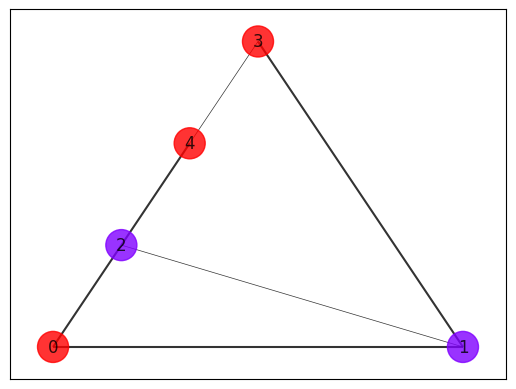

In [16]:
edge_widths = [
    is_cross_cut_edge(
        int(most_probable_result.state[f"x{i}"]),
        int(most_probable_result.state[f"x{j}"]),
    )
    + 0.5
    for i, j in G.edges
]
node_colors = [int(most_probable_result.state[f"x{i}"]) for i in G.nodes]
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    alpha=0.8,
    node_size=500,
    node_color=node_colors,
    width=edge_widths,
    cmap=plt.cm.rainbow,
)


## References

<a id='MaxCutWiki'>[1]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)
